# Tutorial on mode classification of melodies with PyCantus

In this tutorial, we demonstrate how to load and preprocess chant data using the PyCantus library and train a classifier to predict the mode of a prepcossed melody. Our approach follows Cornelissen et al. (ISMIR 2020, [GitHub](https://github.com/bacor/ismir2020)).




The task is to classify a melody into one of the eight medieval modes. A melody is encoded in volpiano notation, for example:

`1---fE--de--fdc---dc---d--ef--g--de--e---dh--hG--g---hk--hg-gfe---e--g---gh--hgfe--de--e77---efg--fe--d---g--f---gh--gfe--dE---e--e---4---h--g--h--k--g--e---3`

This notation is first normalized into a sequence of pitches, ignoring liquescents, clefs and word boundaries, yielding:

`fedefdcdcdefgdeedhhgghkhggfeegghhgfedeeefgfedgfghgfedeee`

The normalized melody is then segmented into melodic units. A simple approach is n-gram segmentation. For example, using 4-grams:

`fede fdcd cdef gdee dhhg ghkh ggfe eggh hgfe deee fgfe dgfg hgfe deee`

These segments (treated as a bag of n-grams) are vectorized using TF-IDF and classified with a Linear SVM to predict the mode - in this example, mode `4`.

PyCantus can also come in handy for replicating the mode classification experiments of Lanz & Hajič jr. (ISMIR 2025, [GitHub](https://github.com/lanzv/chant-modality-with-nhpylms)), where naive n-grams (or segmentation into natural units - words/syllables - [which later proved less effective](https://dl.acm.org/doi/pdf/10.1145/3625135.3625143)) were replaced by segments predicted by a Bayesian non-parametric NHPYLM model ([code](https://github.com/lanzv/nhpylm)), thereby improving mode classification performance.

## Load Data

Load the full CantusCorpus v1.0 as one of the pycantus available datasets.  
(If data files are not ready, pycantus will download them.)

In [1]:
import pycantus
from pycantus import data

In [2]:
# Load the full CantusCorpus v1.0 dataset
cantuscorpus = data.load_dataset('cantuscorpus_v1.0', load_editable=True, create_missing_sources=True)

print(f'Number of chants before filtering: {len(cantuscorpus.chants)}')

Loading chants and sources...
Creating missing sources...
0 missing sources created!
Data loaded!
Number of chants before filtering: 888010


## Filter Melodies

1. Apply PyCantus filters to select Antiphon (`A`) melodies with simple modes (`1–8`).
    - *To explore responsories instead, replace `antiphon_filter.add_value_include('genre', 'A')` with `antiphon_filter.add_value_include('genre', 'R')`.*

2. Remove incomplete melodies.

3. Normalize volpiano sequences into pitch sequences.

In [3]:
# 1. Apply PyCantus filters
from pycantus.filtration import Filter

# Create a filter for antiphons with simple modes
antiphon_filter = Filter('antiphon_filter')
antiphon_filter.add_value_include('genre', 'A')
antiphon_filter.add_value_include('mode', ['1','2','3','4','5','6','7','8'])

# Apply the filter to the dataset
cantuscorpus.apply_filter(antiphon_filter)

print(f'Number of antiphon chants with simple modes: {len(cantuscorpus.chants)}')

Number of antiphon chants with simple modes: 171099


In [4]:
# 2. Remove incomplete melodies.
# Drops chants that do not have complete melodic and textual data.
cantuscorpus.drop_incomplete_chants()

print(f'Number of complete antiphon chants with simple modes: {len(cantuscorpus.chants)}')

Number of complete antiphon chants with simple modes: 14336


In [5]:
# 3. Normalize volpiano melodies (keep pitches only):
# remove differentiae, normalize liquescents, remove word/syllable boundaries and clefs
for melody in cantuscorpus.melody_objects:
    melody.normalize_volpiano()

## Prepare Data for Mode Classification

The PyCantus Corpus object `cantuscorpus` contains all the chants needed for training. We now want to:

1. Collect all pitch sequences (without duplicates) along with their corresponding modes.

2. Segment each pitch sequence into melodic units.

3. Split the data into training and testing sets.

The final training data should be a list of segmented melodies, with segments separated by spaces, for example:

`fede fdcd cdef gdee dhhg ghkh ggfe eggh hgfe deee fgfe dgfg hgfe deee`


Each sequence will have a corresponding class label (modes `1–8`).
We will use a 7:3 ratio for splitting training and testing sets, ensuring that the test set contains sequences distinct from the training set.

In [6]:
# 1. Collect all pitch sequences (without duplicates) along with their corresponding modes.

all_melodies = []
all_modes = []
seen_melodies = set()

for melody in cantuscorpus.melody_objects:
    mel_str = str(melody)
    if mel_str in seen_melodies:
        continue  # skip duplicates
    all_melodies.append(mel_str)
    all_modes.append(melody.mode)
    seen_melodies.add(mel_str)

print(f'Number of unique complete antiphon chants with simple modes: {len(all_melodies)}')

Number of unique complete antiphon chants with simple modes: 13380


In [7]:
print(sorted(set(all_modes)))
for i in range(4):
    print(all_melodies[i], all_modes[i])

['1', '2', '3', '4', '5', '6', '7', '8']
fedefdcdcdefgdeedhhgghkhggfeegghhgfedeeefgfedgfghgfedeee 4
fedefdcdcdfgdeedhhghkhggfedefghhgfedeeefgfedcgfghgfedeee 4
dffefdedcddedefddeddcdaddeddefghghjhhgffedffecdfffededcddcadcdfecefd 2
dfefdfdcddfddefdfedcdcddfddffghghijhhgffedffecdfffedfecddcacdfeccfd 2


In [8]:
# 2. Segment each pitch sequence into melodic units
def segment_melody(melody, n=4):
    return " ".join(melody[i:i+n] for i in range(0, len(melody), n))

# Show example before segmentation
print("Before segmentation:", all_melodies[0])

# Apply segmentation to all melodies
all_segmentations = [segment_melody(mel, n=4) for mel in all_melodies]

# Show example after segmentation
print("After segmentation: ", all_segmentations[0])

Before segmentation: fedefdcdcdefgdeedhhgghkhggfeegghhgfedeeefgfedgfghgfedeee
After segmentation:  fede fdcd cdef gdee dhhg ghkh ggfe eggh hgfe deee fgfe dgfg hgfe deee


In [9]:
# 3. Split the data into training and testing sets
from sklearn.model_selection import train_test_split

seg_train, seg_test, mode_train, mode_test = train_test_split(
    all_segmentations,
    all_modes,
    test_size=0.3,
    shuffle=True,
    random_state=42
)

print(f"Number of training sequences: {len(seg_train)}, testing sequences: {len(seg_test)}")

Number of training sequences: 9366, testing sequences: 4014


## Classify Modes with Linear SVM

Next, we train a Linear SVM classifier on the segmented melodies from the training set. The melodies are vectorized using TF-IDF to represent each sequence as a bag of n-grams, and the classifier predicts the corresponding mode.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import numpy as np

# Initialize TF-IDF vectorizer parameters
tfidf_params = dict(
    strip_accents=None,
    stop_words=None,
    ngram_range=(1,1),
    max_df=1.0,
    min_df=1,
    max_features=5000,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=False,
    lowercase=False,
    analyzer='word',
    token_pattern=r'[^ ]+'
)

# Initialize LinearSVC parameters
svc_params = {
    'penalty': 'l2',
    'loss': 'squared_hinge',
    'multi_class': 'ovr',
    'random_state': np.random.randint(100)
}

# Create a pipeline: TF-IDF vectorizer + Linear SVM
classification_pipeline = Pipeline([
    ('vect', TfidfVectorizer(**tfidf_params)),
    ('clf', LinearSVC(**svc_params)),
])

# Fit the classifier on training data
classification_pipeline.fit(seg_train, mode_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(lowercase=False, max_features=5000,
                                 token_pattern='[^ ]+')),
                ('clf', LinearSVC(random_state=55))])

## Evaluation

Now we use the trained classifier to predict the modes of unseen melodies based on their segmented n-grams.

In [11]:
# Predict modes for the test melodies
preds = classification_pipeline.predict(seg_test)

Compute F1-score and Accuracy by comparing the predicted modes to the true (gold) labels.

In [12]:
from sklearn.metrics import f1_score, accuracy_score

# Compute weighted F1 score
f1 = f1_score(mode_test, preds, average='weighted')
print(f"Weighted F1 score: {100*f1:.2f}%")

# Compute accuracy
acc = accuracy_score(mode_test, preds)
print(f"Accuracy: {100*acc:.2f}%")

Weighted F1 score: 90.73%
Accuracy: 90.91%


Let's print the confusion matrix to visualize which modes are commonly misclassified. We can observe confusion occurring particularly between mode pairs 1–2, 3–4, 5–6, and 7–8, with the strongest confusion for 1–2 and 7–8. This is expected, as modes within each pair share many similar features and characteristics.

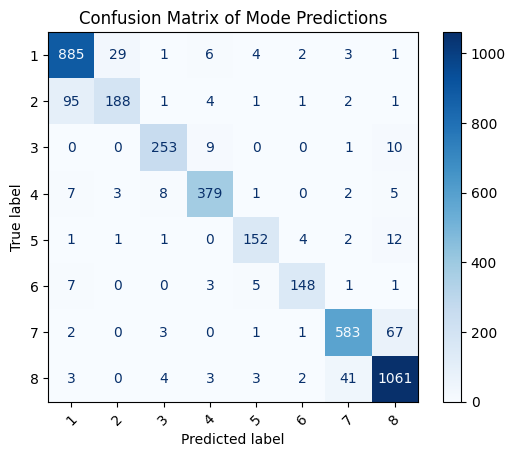

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Compute confusion matrix
labels = np.unique(mode_test)
cm = confusion_matrix(mode_test, preds, labels=labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix of Mode Predictions")
plt.show()